https://stackoverflow.com/questions/62233013/error-using-k-means-to-detect-qpsk-symbols-indexerror-arrays-used-as-indices-m

Modelo: qpsk_template.ipynb

In [26]:
# Importando as bibliotecas necessárias:
import numpy as np
import matplotlib.pyplot as plt

# Importando as bibliotecas Scikit Learn:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [27]:
# Import all necessary libraries.
import numpy as np
from scipy.special import erfc
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [45]:
# Number of QPSK symbols to be transmitted.
N = 1000000

In [46]:
def mod(V):

    ip = np.zeros((len(V),1),dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s


def demod(c):
    c_seq = mod(np.array([0,1,2,3]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [48]:
# Create Es/N0 vector.
EsN0dB = np.arange(-2,22,2)

ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))
for idx in range(0,len(EsN0dB)):
   
    print('Es/N0 dB:', EsN0dB[idx])
   
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))   
    
    # Generate N binary symbols.
    ip = np.random.randint(0,4,(N,1))
   
    # Modulate binary stream into QPSK symbols.
    s = mod(ip)
   
    # Generate noise vector with unitary variance.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
   
    # Pass symbols through AWGN channel.
    y = s + np.sqrt(EsN0Lin)*noise
   
    # Split array into random train and test subsets.
    s_test, s_train, y_test, y_train, v_test, v_train = train_test_split(s, y, ip)
   
    y_c_train = np.c_[y_train.real,y_train.imag]
    y_c_teste = np.c_[y_test.real,y_test.imag]   
    
    # Fit models for real and imaginary parts.
    km = KMeans(n_clusters=4, random_state=42)
    km.fit(y_c_train)
   
    # Prediction.
    detected = km.predict(y_c_teste)  
       
    # Simulated QPSK BER.
    error = 0
    for i in range(0, len(v_test)):
        pred = km.cluster_centers_[detected[i],0] + 1j*km.cluster_centers_[detected[i],1]
        d = demod(pred)
        if((v_test[i,0] != d)==True):
            error = error + 1
   
    ser_simu[idx] = 1.0 * error / len(v_test)
    
    # Theoretical QPSK BER.    
    ser_theo[idx] = erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))) - (1/4)*(erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))))**2.0

Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


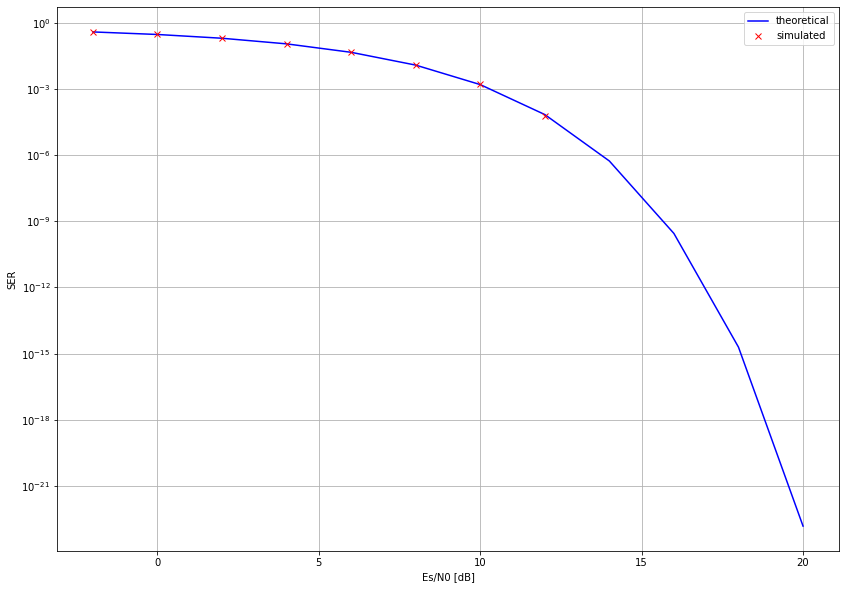

In [49]:
fig = plt.figure(figsize=(14,10))
plt.plot(EsN0dB, ser_theo, 'b', label='theoretical')
plt.plot(EsN0dB, ser_simu, 'rx', label='simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.legend()
plt.show()

# **Resposta teórica**

Bem, conforme mostrado no gráfico. A curva se aproxima da teórica.